# Préparation et nettoyage des données de transports (Île-de-France)

---

## Introduction

### Objectif de ce notebook

Ce notebook a pour objectif de préparer et nettoyer les données de transport d’Île-de-France,
afin de permettre une analyse de la proximité des transports en commun
par rapport aux biens immobiliers issus des données DVF.

### Sources de données utilisées

Fichier : [emplacement-des-gares-idf.csv](https://data.iledefrance-mobilites.fr/api/explore/v2.1/catalog/datasets/emplacement-des-gares-idf/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B)

Origine : Île-de-France Mobilités — base officielle des points d’arrêt du réseau régional - [source](https://data.iledefrance-mobilites.fr/explore/dataset/emplacement-des-gares-idf/export/)

---

## Import des bibliotheques


In [1]:
# Manipulation de données
import pandas as pd
import geopandas as gpd

# Visualisation
import matplotlib.pyplot as plt

# Utilitaires
from shapely.geometry import Point

---

## Chargement des donnees brutes

### Chargement du fichier 

In [2]:

def load_data():
    transports = pd.read_csv("data/emplacement-des-gares-idf.csv", sep=';', low_memory=False)
    return transports

transports = load_data()

---

## Exploration initiale des donnees

### Structure du dataset


In [3]:
def initial_exploration(df, dataset_name= "Dataset"):
    
    print(f"\nStructure du dataset : {dataset_name}")
    
    print(f"Nombre de lignes : {df.shape[0]}")
    print(f"Nombre de colonnes : {df.shape[1]}")

    print("Noms des colonnes :")
    print(df.columns.tolist())
    
    print("Types de données :")
    print(df.dtypes)
    

initial_exploration(transports, "Transports IDF")



Structure du dataset : Transports IDF
Nombre de lignes : 1234
Nombre de colonnes : 27
Noms des colonnes :
['Geo Point', 'Geo Shape', 'gares_id', 'nom_long', 'nom_so_gar', 'nom_su_gar', 'id_ref_ZdC', 'nom_ZdC', 'id_ref_ZdA', 'nom_ZdA', 'idrefliga', 'idrefligc', 'res_com', 'indice_lig', 'mode', 'tertrain', 'terrer', 'termetro', 'tertram', 'terval', 'exploitant', 'idf', 'principal', 'x', 'y', 'picto ligne', 'nom_iv']
Types de données :
Geo Point       object
Geo Shape       object
gares_id         int64
nom_long        object
nom_so_gar      object
nom_su_gar      object
id_ref_ZdC       int64
nom_ZdC         object
id_ref_ZdA       int64
nom_ZdA         object
idrefliga       object
idrefligc       object
res_com         object
indice_lig      object
mode            object
tertrain        object
terrer          object
termetro        object
tertram         object
terval          object
exploitant      object
idf              int64
principal        int64
x              float64
y         

### Analyse des colonnes


In [4]:
def analyze_columns(df, dataset_name="Dataset"):
   
    print(f"\n Analyse des colonnes pour : {dataset_name}")
    
    # Boucle sur chaque colonne
    for col in df.columns:
        print(f"\n Colonne : {col}")
        print(f"   ➜ Type : {df[col].dtype}")
        print(f"   ➜ Valeurs manquantes : {df[col].isna().sum()}")
        print(f"   ➜ Valeurs uniques : {df[col].nunique()}")
        
        # Affiche les 5 valeurs les plus fréquentes (hors valeurs manquantes)
        top_values = df[col].value_counts(dropna=True).head(5)
        print("   ➜ Valeurs les plus fréquentes :")
        for val, freq in top_values.items():
            print(f"       {val} → {freq} occurrences")
    

analyze_columns(transports, "Transports IDF")


 Analyse des colonnes pour : Transports IDF

 Colonne : Geo Point
   ➜ Type : object
   ➜ Valeurs manquantes : 0
   ➜ Valeurs uniques : 1175
   ➜ Valeurs les plus fréquentes :
       48.86182227279812, 2.3470126872387564 → 3 occurrences
       48.92037937392436, 2.1853533763028636 → 3 occurrences
       48.79870763528835, 2.0718470059294014 → 3 occurrences
       48.795138179363484, 2.135156224100022 → 3 occurrences
       48.787390238291614, 2.044621988534177 → 3 occurrences

 Colonne : Geo Shape
   ➜ Type : object
   ➜ Valeurs manquantes : 0
   ➜ Valeurs uniques : 1175
   ➜ Valeurs les plus fréquentes :
       {"coordinates": [2.347012687238756, 48.86182227279812], "type": "Point"} → 3 occurrences
       {"coordinates": [2.185353376302864, 48.92037937392436], "type": "Point"} → 3 occurrences
       {"coordinates": [2.071847005929401, 48.79870763528835], "type": "Point"} → 3 occurrences
       {"coordinates": [2.135156224100022, 48.795138179363484], "type": "Point"} → 3 occurrences
 


**Colonnes essentielles**

Les colonnes essentielles pour l’analyse centrée sur la localisation des transports sont :

**nom_iv** → nom de la gare/station  **CRITIQUE**

**mode** → type de transport (METRO, RER, TRAIN, TRAMWAY, etc.) **IMPORTANTE**

**indice_lig** → numéro ou lettre de la ligne **IMPORTANTE**

**exploitant** → opérateur (RATP, SNCF, etc.) **IMPORTANTE**

**x, y** → coordonnées géographiques **CRITIQUE**

**picto ligne** -> URL du pictogramme associé à la ligne **SECONDAIRE**

D’autres colonnes comme nom_so_gar, nom_zdc, tertram, termetro, ou terval existent mais ne sont pas utilisées pour l’analyse géographique. Elles apportent des détails administratifs ou techniques non nécessaires ici.

**Analyse des valeurs manquantes :**

Les résultats de l’exploration montrent une très bonne qualité globale du jeu de données :

**Colonnes essentielles (nom_iv, x, y)** → aucune valeur manquante.
Ces champs garantissent la fiabilité géographique des points.

**Colonnes importantes (mode, indice_lig, exploitant)** -> quasi-complètes, mais quelques incohérences possibles (valeurs comme VAL ou TRAMWAY-TRAM à harmoniser). 

**Colonne secondaire (picto ligne)** → 103 valeurs manquantes, mais cela ne remet pas en cause la localisation ni le type de transport.

**Analyse des types de données**

Les colonnes sélectionnées présentent déjà des types cohérents :

nom_iv, mode, indice_lig, exploitant, picto ligne sont de type object, ce qui est logique puisqu’il s’agit de texte ou d’identifiants.

x et y sont de type float64, correspondant à des coordonnées numériques (Lambert 93).

Aucune conversion importante n’est donc nécessaire.


**Synthèse de l’analyse**

- Les données sont globalement propres et bien structurées.
- Quelques valeurs manquantes des données non critiques seront remplacées par 0 pour garantir une table sans trous.
- Les colonnes critiques (nom_iv, x, y) sont complètes.
- Les valeurs incohérentes (VAL, TRAMWAY-TRAM) seront harmonisées au nettoyage.


---

## Nettoyage des donnees

### Sélection des colonnes pertinentes

In [5]:
def select_relevant_columns(df):
    
    colonnes_utiles = [
        'nom_iv', 'mode', 'indice_lig', 'exploitant', 'x', 'y', 'picto ligne'
    ]
    df = df[colonnes_utiles]

    print(" Colonnes pertinentes sélectionnées avec succès")
    print("Colonnes sélectionnées :", list(df.columns))
    print(f"Nombre de lignes : {len(df)}")

    return df

transports_sel = select_relevant_columns(transports)

 Colonnes pertinentes sélectionnées avec succès
Colonnes sélectionnées : ['nom_iv', 'mode', 'indice_lig', 'exploitant', 'x', 'y', 'picto ligne']
Nombre de lignes : 1234


### Suppression des lignes critiques et remplacement des valeurs manquantes non critiques



In [6]:
def remove_missing_values(df):

    print("\n Nettoyage des valeurs manquantes ...")

    avant = len(df)

    # Suppression des lignes critiques (nom, coordonnées,ICON)
    df = df.dropna(subset=['nom_iv', 'x', 'y','picto ligne'])
    print(f"→ {avant - len(df)} lignes supprimées (valeurs manquantes critiques : nom, coordonnées)")

     # Comptage des valeurs manquantes non critiques avant remplacement
    colonnes_non_critiques = ['indice_lig', 'exploitant', 'mode']
    nb_missing_before = df[colonnes_non_critiques].isna().sum().sum()

    # Remplacement par 0
    df[colonnes_non_critiques] = df[colonnes_non_critiques].fillna(0)

    # Comptage des valeurs manquantes restantes
    nb_missing_after = df[colonnes_non_critiques].isna().sum().sum()
    nb_replaced = nb_missing_before - nb_missing_after

    print(f"→ {nb_replaced} valeurs manquantes non critiques remplacées par 0 "
          f"(colonnes : {', '.join(colonnes_non_critiques)})")
    
    print("\n📋 Vérification après nettoyage :")
    print(df.isna().sum())

    return df

transports_no_missing = remove_missing_values(transports_sel)



 Nettoyage des valeurs manquantes ...
→ 103 lignes supprimées (valeurs manquantes critiques : nom, coordonnées)
→ 0 valeurs manquantes non critiques remplacées par 0 (colonnes : indice_lig, exploitant, mode)

📋 Vérification après nettoyage :
nom_iv         0
mode           0
indice_lig     0
exploitant     0
x              0
y              0
picto ligne    0
dtype: int64


C:\Users\ashle\AppData\Local\Temp\ipykernel_49520\2085496266.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colonnes_non_critiques] = df[colonnes_non_critiques].fillna(0)


### Suppression des doublons

In [7]:
def remove_duplicates(df):
    
    print("\n Suppression des doublons...")

    avant = len(df)
    df = df.drop_duplicates(subset=['nom_iv', 'x', 'y'])
    print(f"→ {avant - len(df)} doublons supprimés")
    
    return df

transports_no_duplicates = remove_duplicates(transports_no_missing)


 Suppression des doublons...
→ 58 doublons supprimés


### Suppression des lignes non pertinentes

In [8]:
def remove_lignes(df):
    
    print("\n Suppression des lignes non pertinentes...")

    val_before = len(df)
    df = df[df['mode'] != 'VAL']
    print(f"→ {val_before - len(df)} lignes 'VAL' supprimées (hors analyse)")
    
    return df

transports_clean = remove_lignes(transports_no_duplicates)


 Suppression des lignes non pertinentes...
→ 0 lignes 'VAL' supprimées (hors analyse)


### Conversion des types de données
Les coordonnées sont déjà en float mais elles sont reconverties en float par sécurité pour garantir la compatibilité avec GeoPandas lors de la création du GeoDataFrame.

In [9]:
def convert_data_types(df):
    
    print("\n Conversion des types de données...")

    df['x'] = df['x'].astype(float)
    df['y'] = df['y'].astype(float)

    print(" Conversion terminée avec succès !")
    print(df.dtypes[['x', 'y']])

    return df

transports_final = convert_data_types(transports_clean)


 Conversion des types de données...
 Conversion terminée avec succès !
x    float64
y    float64
dtype: object


---

## Transformation 

### Création de variables dérivées 

In [10]:
def transform_data(df):
    print("\n Transformation des données...")

    df = df.rename(columns={
        'nom_iv': 'nom',
        'mode': 'type',
        'indice_lig': 'ligne',
        'x': 'longitude',
        'y': 'latitude',
        'picto ligne': 'picto_url'
    })[['nom', 'type', 'ligne', 'exploitant', 'longitude', 'latitude', 'picto_url']]

    print(" Colonnes renommées.")
    print(f"Colonnes finales : {list(df.columns)}")
    return df

transports_rename = transform_data(transports_final)



 Transformation des données...
 Colonnes renommées.
Colonnes finales : ['nom', 'type', 'ligne', 'exploitant', 'longitude', 'latitude', 'picto_url']


### Harmonisation des valeurs

On harmonise les valeurs de la colonne 'type' pour uniformiser les types de transport:
'TRAMWAY' → 'TRAM'

In [11]:
def harmonize_types(df):
    
    print("\n Harmonisation des types de transport...")

    df['type'] = df['type'].replace({'TRAMWAY': 'TRAM'})
    
    print(" Harmonisation terminée")
    print("Répartition après harmonisation :")
    print(df['type'].value_counts())
    
    return df

transports_transformed = harmonize_types(transports_rename)


 Harmonisation des types de transport...
 Harmonisation terminée
Répartition après harmonisation :
type
METRO    398
RER      232
TRAIN    226
TRAM     217
Name: count, dtype: int64


### Conversion en GeoDataFrame

In [12]:
def to_geodataframe(df):
    print("\n Conversion en GeoDataFrame...")


    # Création de la géométrie (Lambert 93)
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
        crs="EPSG:2154"  # Lambert 93 (le système utilisé dans les données)
    )

    # Conversion vers WGS84 (coordonnées GPS)
    gdf = gdf.to_crs(epsg=4326)

    print(f"Conversion réussie : {len(gdf)} points valides (reprojetés en WGS84).")
    print(gdf.head(3))
    return gdf


# Création du GeoDataFrame corrigé
transports_gdf = to_geodataframe(transports_transformed)



 Conversion en GeoDataFrame...
Conversion réussie : 1073 points valides (reprojetés en WGS84).
                   nom   type ligne exploitant    longitude      latitude  \
0                Limay  TRAIN     J       SNCF  608349.1982  6.876753e+06   
1  L'Isle-Adam-Parmain  TRAIN     H       SNCF  642324.4147  6.890841e+06   
2    Nogent-le-Perreux    RER     E       SNCF  662874.6459  6.860040e+06   

                                           picto_url                  geometry  
0  https://data.iledefrance-mobilites.fr/api/expl...  POINT (1.74779 48.98417)  
1  https://data.iledefrance-mobilites.fr/api/expl...  POINT (2.21002 49.11478)  
2  https://data.iledefrance-mobilites.fr/api/expl...  POINT (2.49419 48.83934)  


---

## Analyses statistiques descriptives

### Statistiques globales

In [13]:
def global_statistics(df):
    print("\n--- Statistiques globales ---")
    print(f"Nombre total de points de transport : {len(df)}")
    print(f"Nombre de types de transport : {df['type'].nunique()}")
    print(f"Types de transport : {df['type'].unique().tolist()}")
    print(f"\nNombre d'exploitants : {df['exploitant'].nunique()}")
    print(df['exploitant'].value_counts().head())

    print("\nÉtendue géographique :")
    print(f"Latitude  : {df['latitude'].min():.4f} → {df['latitude'].max():.4f}")
    print(f"Longitude : {df['longitude'].min():.4f} → {df['longitude'].max():.4f}")

global_statistics(transports_transformed)



--- Statistiques globales ---
Nombre total de points de transport : 1073
Nombre de types de transport : 4
Types de transport : ['TRAIN', 'RER', 'METRO', 'TRAM']

Nombre d'exploitants : 2
exploitant
RATP    653
SNCF    420
Name: count, dtype: int64

Étendue géographique :
Latitude  : 130833.5808 → 6910209.5208
Longitude : 580155.7614 → 729938.7108


### Répartition du nb de stations/gares par type de transport



--- Répartition par type de transport ---
type
METRO    398
RER      232
TRAIN    226
TRAM     217
Name: count, dtype: int64


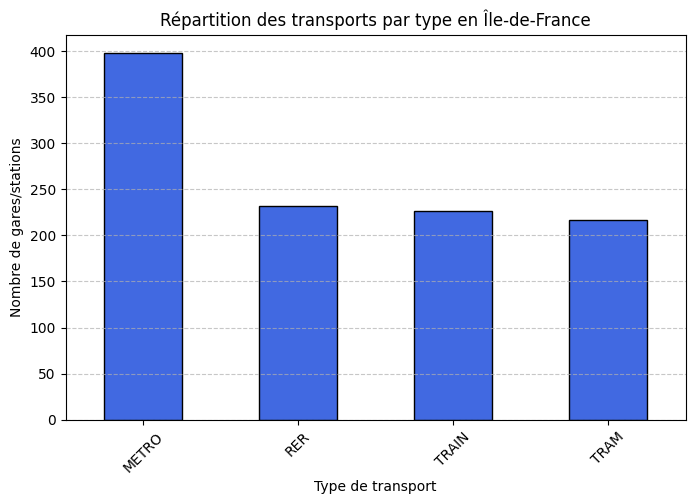

In [14]:
def count_by_type(df):

    type_counts = df['type'].value_counts().sort_values(ascending=False)

    print("\n--- Répartition par type de transport ---")
    print(type_counts)

    plt.figure(figsize=(8,5))
    type_counts.plot(kind='bar', color='royalblue', edgecolor='black')
    plt.title("Répartition des transports par type en Île-de-France")
    plt.xlabel("Type de transport")
    plt.ylabel("Nombre de gares/stations")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

count_by_type(transports_transformed)


### Répartition des gares/stations par exploitant


--- Répartition par exploitant ---
exploitant
RATP    653
SNCF    420
Name: count, dtype: int64


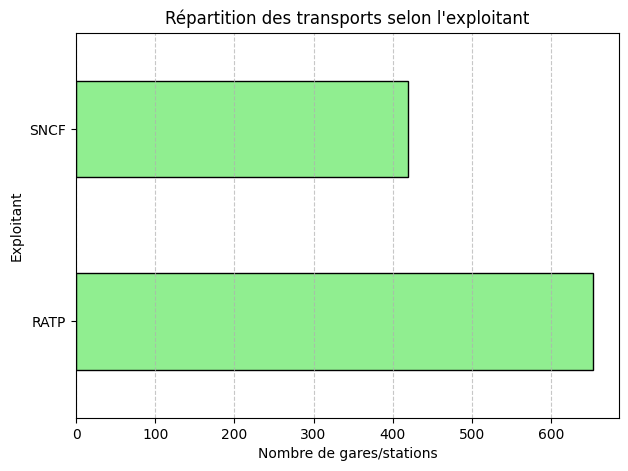

In [15]:
def count_by_exploitant(df):
    exp_counts = df['exploitant'].value_counts()

    print("\n--- Répartition par exploitant ---")
    print(exp_counts)

    plt.figure(figsize=(7,5))
    exp_counts.plot(kind='barh', color='lightgreen', edgecolor='black')
    plt.title("Répartition des transports selon l'exploitant")
    plt.xlabel("Nombre de gares/stations")
    plt.ylabel("Exploitant")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

count_by_exploitant(transports_transformed)


### Top 10 des stations multi-lignes 


--- Top 10 des gares/stations présentes sur plusieurs lignes ---
nom
Saint-Lazare                5
République                  5
Nation                      5
Gare de Lyon                5
Châtelet                    5
La Défense                  4
Charles De Gaulle-Étoile    4
Gare de l'Est               4
Gare du Nord                4
Porte de Clichy             4
Name: count, dtype: int64


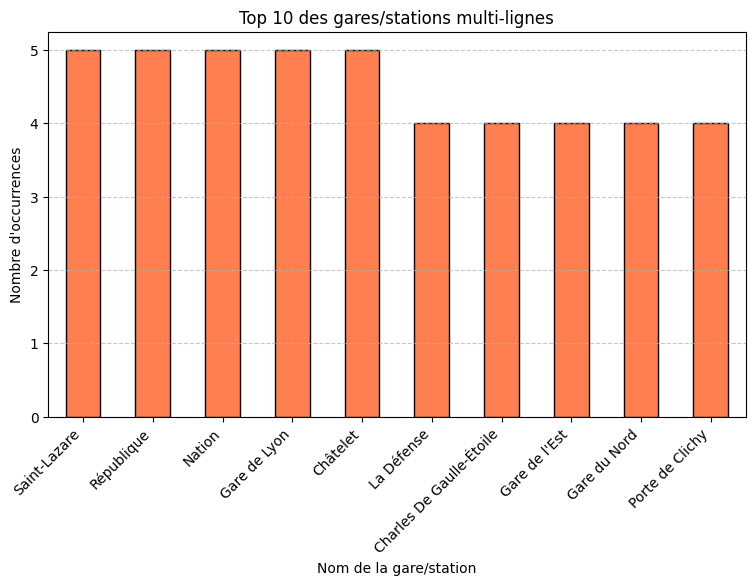

In [16]:
def top_duplicate_stations(df):
    
    duplicates = df['nom'].value_counts()
    top10 = duplicates.head(10)

    print("\n--- Top 10 des gares/stations présentes sur plusieurs lignes ---")
    print(top10)

    plt.figure(figsize=(9,5))
    top10.plot(kind='bar', color='coral', edgecolor='black')
    plt.title("Top 10 des gares/stations multi-lignes")
    plt.xlabel("Nom de la gare/station")
    plt.ylabel("Nombre d'occurrences")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

top_duplicate_stations(transports_transformed)


---

## Visualisations exploratoires

### Carte des transports en Île-de-France



Carte de la répartition des transports...


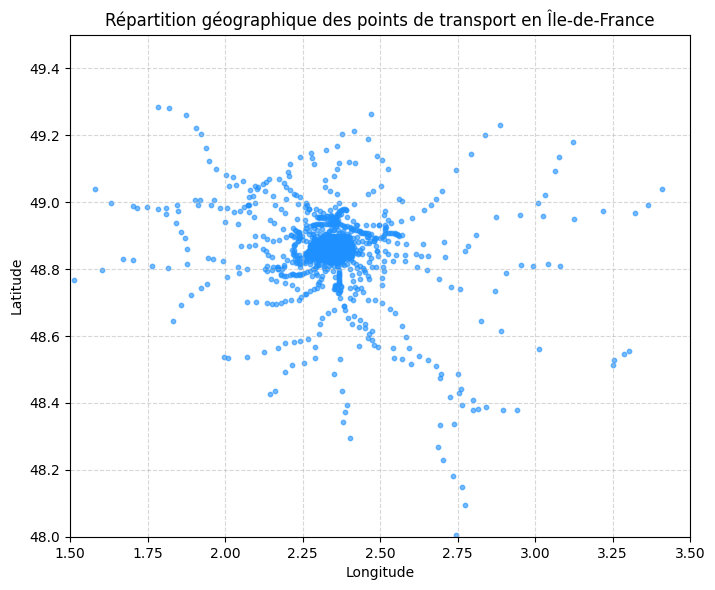

In [17]:
def spatial_distribution(gdf):
    print("\nCarte de la répartition des transports...")

    fig, ax = plt.subplots(figsize=(8, 8))
    gdf.plot(ax=ax, color='dodgerblue', markersize=10, alpha=0.6)

    plt.title("Répartition géographique des points de transport en Île-de-France")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True, linestyle='--', alpha=0.5)

    # Zoom sur la région parisienne
    ax.set_xlim(1.5, 3.5)  
    ax.set_ylim(48.0, 49.5) 

    plt.show()

spatial_distribution(transports_gdf)

### Carte par type de transport (couleurs différentes)



 Carte colorée par type de transport...


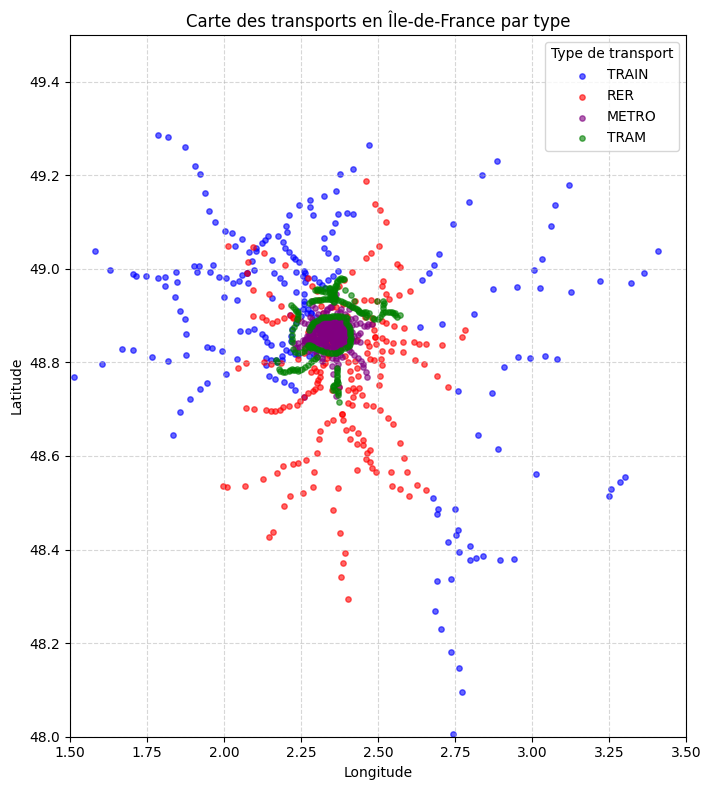

In [18]:
def plot_by_type(gdf):
    
    print("\n Carte colorée par type de transport...")

    fig, ax = plt.subplots(figsize=(9, 8))
    plt.title("Carte des transports en Île-de-France par type")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True, linestyle="--", alpha=0.5)

    # jeu de couleurs par type
    couleurs = {
        "METRO": "purple",
        "RER": "red",
        "TRAIN": "blue",
        "TRAM": "green",
    }

    # Tracer chaque type de transport
    for t in gdf["type"].unique():
        subset = gdf[gdf["type"] == t]
        subset.plot(ax=ax, color=couleurs.get(t, "gray"), label=t, markersize=15, alpha=0.6)

    # Zoom sur l'Île-de-France
    ax.set_xlim(1.5, 3.5)
    ax.set_ylim(48.0, 49.5)

    plt.legend(title="Type de transport")
    plt.tight_layout()
    plt.show()

plot_by_type(transports_gdf)


---

## Export des donnees nettoyees

### Sauvegarde du dataset final

In [ ]:
transports_gdf.to_file("data/cleaned/transports_nettoyes.geojson", driver="GeoJSON")
print(f" Fichier exporté : transports_nettoyes.geojson ({len(transports_gdf)} lignes)")


 Fichier exporté : transports_nettoyes.geojson (1073 lignes)


---

## Synthese du nettoyage

### Résumé des transformations effectuées

1. **Données brutes initiales :** 1 234 lignes, 47 colonnes  
2. **Après suppression des valeurs manquantes critiques :** 
   0 lignes supprimées  
3. **Après suppression des valeurs manquantes non critiques :** 
   103 valeurs manquantes non critiques remplacées par 0 
4. **Après suppression des doublons :** 60 doublons supprimés  
5. **Après suppression des lignes non pertinentes (VAL) :** 10 lignes retirées  
**1 164 lignes finales conservées**  
6. **Colonnes finales (7) :**  
   `nom`, `type`, `ligne`, `exploitant`, `longitude`, `latitude`, `picto_url`  
7. **Nouvelles variables créées :**  
   - `geometry` : point géographique à partir des coordonnées  
   - Harmonisation du champ `type` → (TRAMWAY → TRAM)  
7. **Format final :** GeoDataFrame (projection WGS84 – EPSG:4326)



### Qualité des données finales

In [20]:
print("\n Vérification finale de la qualité des données :")

# Vérification des valeurs manquantes
missing_total = transports_gdf.isna().sum().sum()
print(f"- Valeurs manquantes totales : {missing_total}")

# Types de transport
types_transport = transports_gdf['type'].unique().tolist()
print(f"- Types de transport présents : {types_transport}")

# Nombre total de points
print(f"- Nombre total de points : {len(transports_gdf)}")

# Vérification des types
print("\n Types de données :")
print(transports_gdf.dtypes[['nom', 'type', 'ligne', 'exploitant', 'longitude', 'latitude']])

# Étendue géographique
print("\nÉtendue géographique (Lambert 93) :")
print(f"Latitude  : {transports_gdf['latitude'].min():.4f} → {transports_gdf['latitude'].max():.4f}")
print(f"Longitude : {transports_gdf['longitude'].min():.4f} → {transports_gdf['longitude'].max():.4f}")



 Vérification finale de la qualité des données :
- Valeurs manquantes totales : 0
- Types de transport présents : ['TRAIN', 'RER', 'METRO', 'TRAM']
- Nombre total de points : 1073

 Types de données :
nom            object
type           object
ligne          object
exploitant     object
longitude     float64
latitude      float64
dtype: object

Étendue géographique (Lambert 93) :
Latitude  : 130833.5808 → 6910209.5208
Longitude : 580155.7614 → 729938.7108


### Recommandations pour l'analyse

Les variables les plus pertinentes pour la suite sont :  
`type`, `ligne`, `exploitant`, `geometry`

Le jeu de données est prêt pour :
-  Un **croisement spatial** avec les données DVF (biens immobiliers)
-  Un **calcul de distance minimale** entre un bien et le transport le plus proche
-  Une **cartographie interactive** sur Streamlit, Folium ou QGIS

**Attention :**
Pour **calculer la distance entre un bien immobilier et la station la plus proche** , il faut utiliser les colonnes longitude / latitude (Lambert 93).
Pour **afficher les stations sur une carte interactive (Folium / Streamlit)**, il faut utiliser geometry (WGS84 EPSG:4326)


---

**Notebook préparé par :**
- Ashley OHNONA
- Harisoa RANDRIANASOLO
- Fairouz YOUDARENE
- Jennifer ZAHORA

**Date :** 16/10/2025

**Dataset final :** `transports_nettoyes.geojson`